# Data Quality Assessment Toolkit (`dqatool`)

---

## 1. Introduction

**dqatool** is a Python package for performing automated data‑quality assessment on radio‑interferometric measurement sets (MS) and images. It provides:

- Functions to detect and flag RFI (`rfi.py`)
- Image creation and manipulation (`imtools.py`)
- Statistical summaries of images (`stats.py`)
- Visualisation helpers (`plotting.py`)
- Central configuration/constants (`constants.py`)
- Standardised logging (`logging_config.py`)

This toolkit is designed to integrate into observatory operations pipelines, enabling:

- **Real‑time data health monitoring**: flagging RFI during observations
- **Automated QC reports**: generating stats and plots
- **Operational alerts**: detecting anomalous behaviour

---

## 2. Analysing the Test Data Set

### Examining the data

The test data set is in the form of a CASA Measurement Set (MS) consisting of a ~30 minute MeerKAT observation at 1.4 GHz of a single CDFS field, consisting of a single scan and correlator dumps at intervals of ~15 seconds. There is a single spectral window of 107 MHz bandwidth, split into 32 frequency channels. All four correlation products are present.

We first plot the visibility amplitudes of all four correlations over time and frequency. This can be achieved by calling plotting routines under `dqatool.plotting`:

```python
from dqatool import plotting
plotting.plot_amp_vs_time(ms_path="pipeline_problem_data.ms", colname='DATA, corrs=[0,1,2,3], in_notebook=False, save_path='amp_vs_time.html')
plotting.plot_amp_vs_time(ms_path="pipeline_problem_data.ms", colname='DATA, corrs=[0,1,2,3], in_notebook=False, save_path='amp_vs_freq.html')
```

Where necessary, we display pre-saved images of plots for the purposes of demonstration.

In [3]:
import matplotlib.image as mpimg # to load images from disk
import matplotlib.pyplot as plt # to plot images

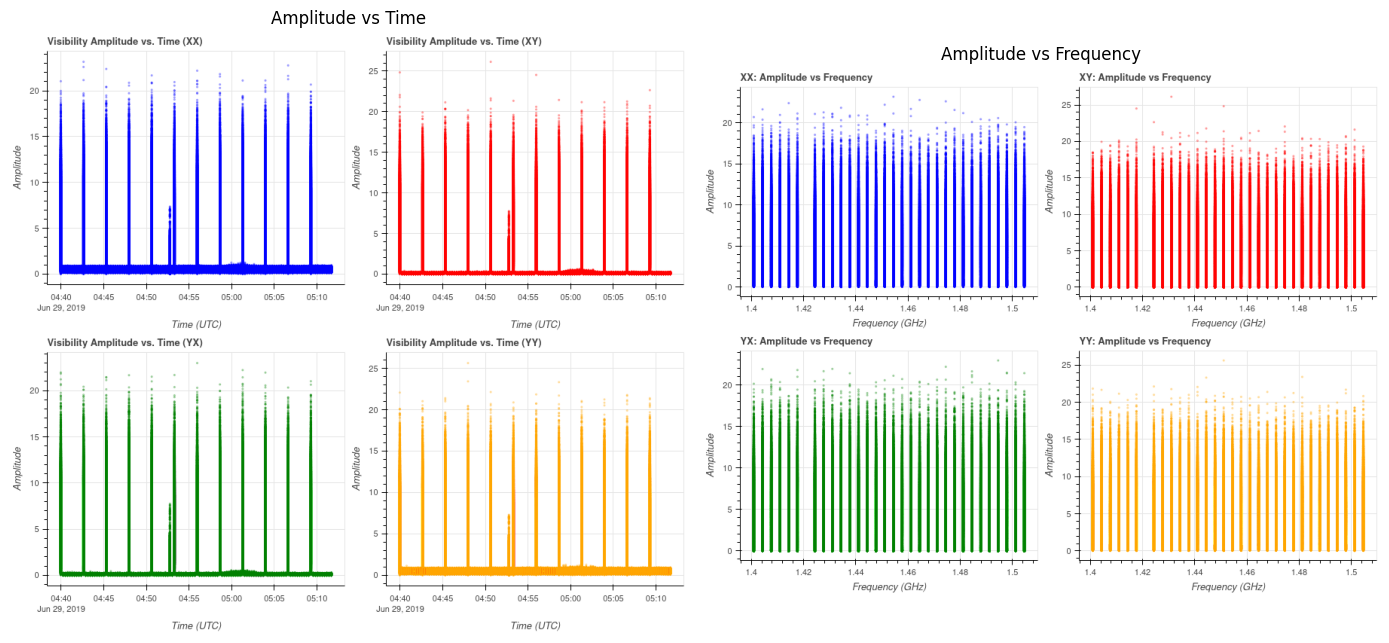

In [4]:
files = [f'images/{fname}' for fname in ['01-noflags-timeplot.png', '02-noflags-freqplot.png']]
labels = ['Amplitude vs Time', 'Amplitude vs Frequency']

# create a 1x2 grid of axes
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14, 18))

for ax, fname, lname in zip(axes, files, labels):
    img = mpimg.imread(fname)
    ax.imshow(img)
    ax.axis('off')          # hide axes ticks/labels
    ax.set_title(lname)     # optional: show filename as title

plt.tight_layout()
plt.show()

### Flagging the RFI

From the above, we see that there are strong RFI spikes throughout the duration of the observation in all four correlation products and they are seen in all frequency channels.

To detect and excise the RFI, we call `rfi.detect_rfi_1d` which computes a rolling median and MAD and flags RFI based on a user-specified threshold and operates on all four correlation products. It then writes out a CASA-compatible flag table in ASCII format consisting of the baselines and times to be flagged and optionally updates the FLAG and FLAG_ROW columns in the MS.

In [5]:
from dqatool import rfi
rfi.detect_rfi_1d(ms_path="pipeline_problem_data.ms", overwriteflags=True, flagfile='rfi_flags.txt')

Processing baselines: 100%|██████████| 1891/1891 [02:49<00:00, 11.18it/s]
2025-05-08 20:05:30,133 - INFO - dqatool.rfi - Flags updated in the MS.
2025-05-08 20:05:30,390 - INFO - dqatool.rfi - RFI detection completed and flags written to rfi_flags.txt.


The following plots show how well the RFI detection algorithm worked.

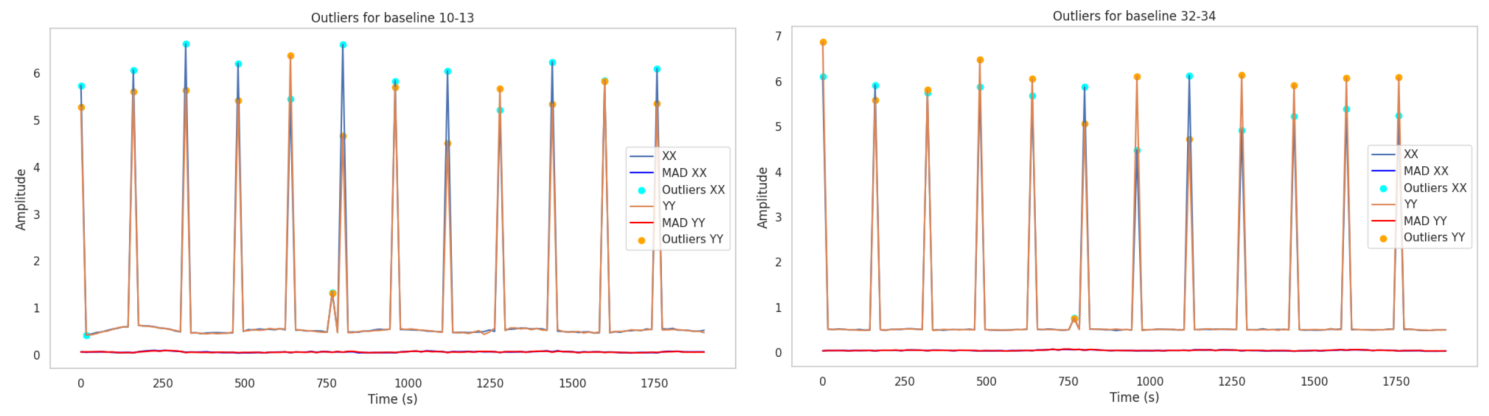

In [8]:
files = [f'images/{fname}' for fname in ['05-outliers-1013.png', '06-outliers-3234.png']]

# create a 1x2 grid of axes
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 30))

for ax, fname in zip(axes, files):
    img = mpimg.imread(fname)
    ax.imshow(img)
    ax.axis('off')          # hide axes ticks/labels

plt.tight_layout()
plt.show()

After flagging RFI, we re‑plot the data to verify that the RFI has been effectively removed.

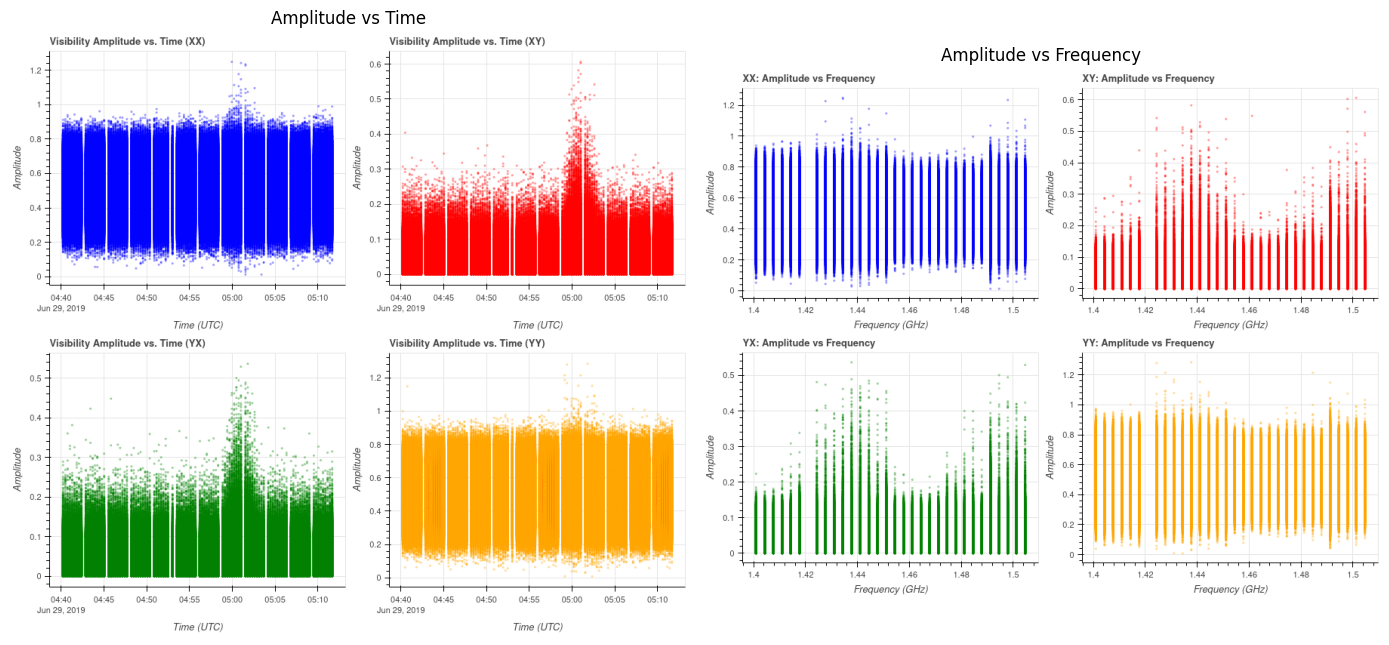

In [6]:
files = [f'images/{fname}' for fname in ['03-flagged-timeplot.png', '04-flagged-freqplot.png']]
labels = ['Amplitude vs Time', 'Amplitude vs Frequency']

# create a 1x2 grid of axes
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14, 18))

for ax, fname, lname in zip(axes, files, labels):
    img = mpimg.imread(fname)
    ax.imshow(img)
    ax.axis('off')          # hide axes ticks/labels
    ax.set_title(lname)     # optional: show filename as title

plt.tight_layout()
plt.show()

We have flagged most of the RFI, except for a small noisy signal around 05:00, distributed around 1.44 GHz and towards the end of the band. in all four correlations. Expanding the RFI detection algorithm to use a 2-D kernel that slides along the frequency axis will help in identifying and removing these low level RFI points.

### Imaging the data set

We image the data before and after flagging the RFI for a side-by-side comparison. The `dqatool.imtools` module contains routines to generate and manipulate images. Currently, only the CASA `tclean` task is supported. But the `make_image` function intends to present a consistent interface to various imaging software packages.


For `tclean` we use the following imaging parameters.

```python
from dqatool import imtools

imager_params = {
    "datacolumn": "data", # use DATA column
    "imsize": [4096, 4096], # make 4096x4096 image
    "cell": "2arcsec", # about one-third of the PSF; combined with imsize, this covers ~2.3 deg. on a side
    "stokes": "I", # total intensity map
    "gridder": "wproject", # use w-projection to correct for wide-field (non-coplanar) effects
    "wprojplanes": 128, # use 128 w-projection planes for reasonable accuracy
    "deconvolver": "hogbom",
    "niter": 100000,
    "threshold": "30uJy",  # 3x the Stokes I noise computed by the SARAO sensitivity calculator
    "pblimit": -0.1,  # avoid pb correction
    "savemodel": "modelcolumn"
}

imtools.make_image("pipeline_problem_data_flagged.ms", "pipeline_problem_data_flagged", imager_name="tclean", imager_params=imager_params)
```

The results of the imaging before and after flagging are shown below.

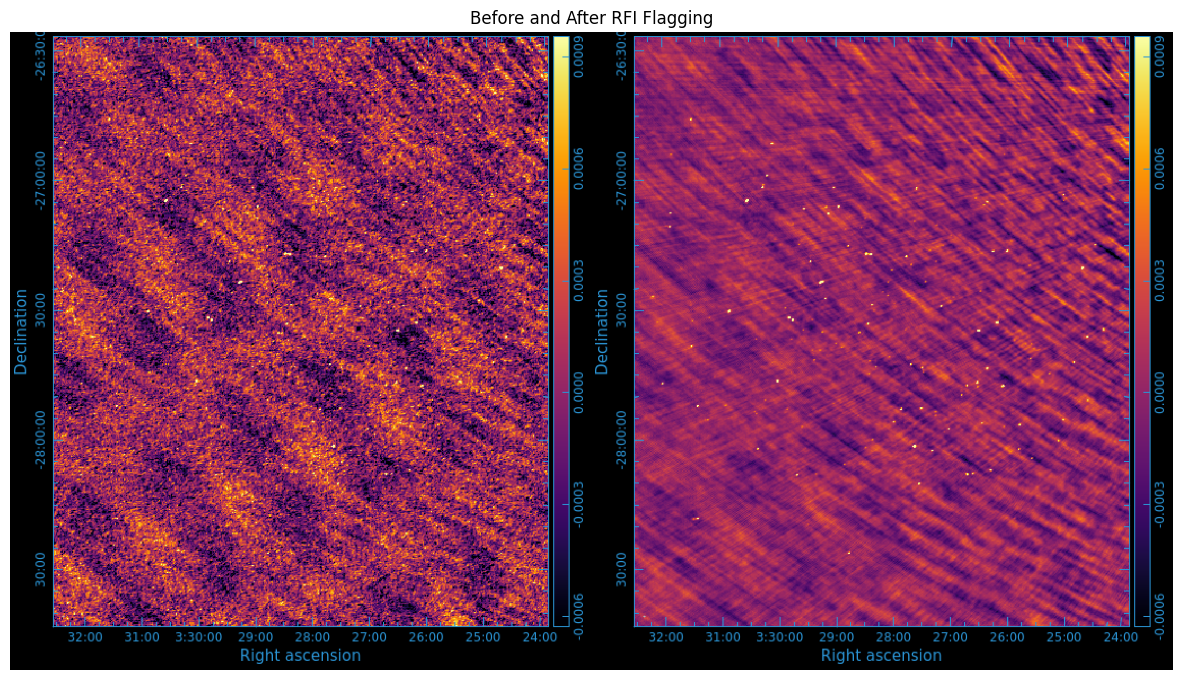

In [11]:
img = mpimg.imread('images/07-image-before-after-rfi.png')

plt.figure(figsize=(15,30))
plt.imshow(img)
plt.axis('off')    # hide axes
plt.title('Before and After RFI Flagging')
plt.show()

We take a quick look at the image rms to see how much the flagging has improved our image using the `dqatool.stats.get_image_stats` function.

In [13]:
from dqatool import stats

boxes = {
    "botleft": (slice(0,100), slice(0,100)),
    "center":  (slice(1950,2050), slice(1950,2050))
}

imstats = stats.get_image_stats("/home/memer/projects/skao_sdp_engineer/assignment/demo/pipeline_problem_data.image", rms_boxes=boxes)

print("Global RMS:", imstats["rms"])
print("Bottom-left RMS:", imstats["rms_botleft"])
print("Center RMS:", imstats["rms_center"])

2025-05-09 00:48:44	INFO	ImageMetaData::summary	
2025-05-09 00:48:44	INFO	ImageMetaData::summary+	Image name       : pipeline_problem_data.image
2025-05-09 00:48:44	INFO	ImageMetaData::summary+	Object name      : CDFS_2_5
2025-05-09 00:48:44	INFO	ImageMetaData::summary+	Image type       : PagedImage
2025-05-09 00:48:44	INFO	ImageMetaData::summary+	Image quantity   : Intensity
2025-05-09 00:48:44	INFO	ImageMetaData::summary+	Pixel mask(s)    : None
2025-05-09 00:48:44	INFO	ImageMetaData::summary+	Region(s)        : None
2025-05-09 00:48:44	INFO	ImageMetaData::summary+	Image units      : Jy/beam
2025-05-09 00:48:44	INFO	ImageMetaData::summary+	Restoring Beam   : 16.9803 arcsec, 10.804 arcsec, -60.5686 deg
2025-05-09 00:48:44	INFO	ImageMetaData::summary	
2025-05-09 00:48:44	INFO	ImageMetaData::summary+	Direction reference : J2000
2025-05-09 00:48:44	INFO	ImageMetaData::summary+	Spectral  reference : LSRK
2025-05-09 00:48:44	INFO	ImageMetaData::summary+	Velocity  type      : RADIO
2025-05-

Global RMS: 0.00045571913901279665
Bottom-left RMS: 0.000438040764463914
Center RMS: 0.000406226607259836


In [21]:
# Now for the flagged image
from dqatool import stats

boxes = {
    "botleft": (slice(0,100), slice(0,100)),
    "center":  (slice(1950,2050), slice(1950,2050))
}

imstats = stats.get_image_stats("/home/memer/projects/skao_sdp_engineer/assignment/demo/pipeline_problem_data_1passflagging.image", rms_boxes=boxes)

print("Global RMS:", imstats["rms"])
print("Bottom-left RMS:", imstats["rms_botleft"])
print("Center RMS:", imstats["rms_center"])

2025-05-09 01:27:23	INFO	ImageMetaData::summary	
2025-05-09 01:27:23	INFO	ImageMetaData::summary+	Image name       : pipeline_problem_data_1passflagging.image
2025-05-09 01:27:23	INFO	ImageMetaData::summary+	Object name      : CDFS_2_5
2025-05-09 01:27:23	INFO	ImageMetaData::summary+	Image type       : PagedImage
2025-05-09 01:27:23	INFO	ImageMetaData::summary+	Image quantity   : Intensity
2025-05-09 01:27:23	INFO	ImageMetaData::summary+	Pixel mask(s)    : None
2025-05-09 01:27:23	INFO	ImageMetaData::summary+	Region(s)        : None
2025-05-09 01:27:23	INFO	ImageMetaData::summary+	Image units      : Jy/beam
2025-05-09 01:27:23	INFO	ImageMetaData::summary+	Restoring Beam   : 16.9578 arcsec, 10.7076 arcsec, -60.5121 deg
2025-05-09 01:27:23	INFO	ImageMetaData::summary	
2025-05-09 01:27:23	INFO	ImageMetaData::summary+	Direction reference : J2000
2025-05-09 01:27:23	INFO	ImageMetaData::summary+	Spectral  reference : LSRK
2025-05-09 01:27:23	INFO	ImageMetaData::summary+	Velocity  type      :

Global RMS: 0.00023365068593795185
Bottom-left RMS: 0.00017125054726175944
Center RMS: 0.00016596657062654298


We can see that the bottom left box of size 100x100 pixels, taken to be approximately representative of an empty area on the sky, has improved from ~400 mJy to ~165 mJy.

Subtracting the RFI‑flagged, imaged data from the model and examining the residuals provides a robust cross‑check on both the flagging and the modelling quality. In this image, the sources found in the RFI-flagged image have been modelled and subtracted away.

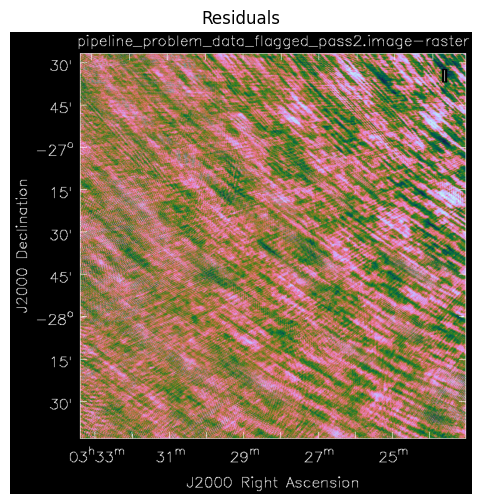

In [22]:
img = mpimg.imread('images/08-residuals.png')

plt.figure(figsize=(6,6))
plt.imshow(img)
plt.axis('off')    # hide axes
plt.title('Residuals')
plt.show()

Despite the improvement, we can still clearly see that there are strong artifacts due to a strong outlying source.

To identify this source, we image a larger area (4x) centred on the same field, with 512 w-projection plans. The results of this imaging are shown below.

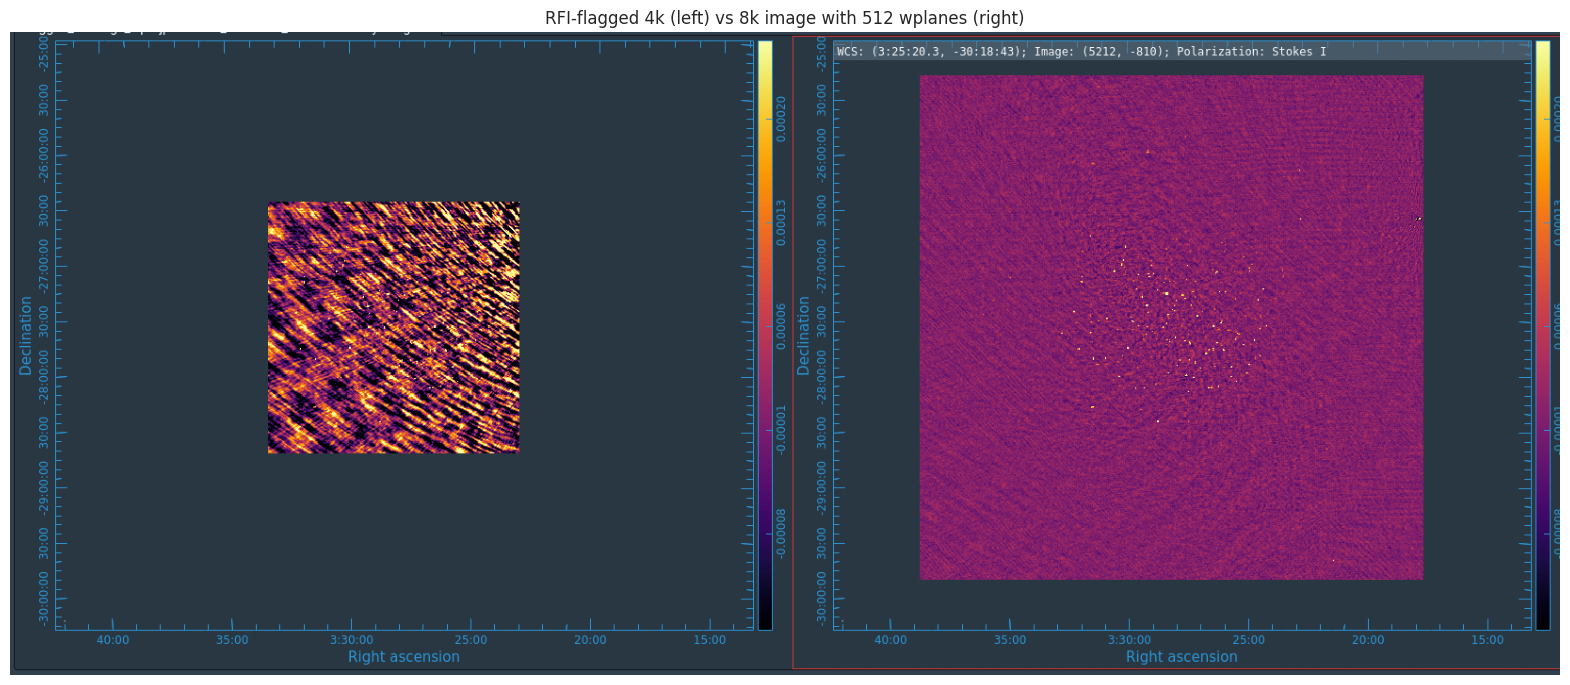

In [35]:
img = mpimg.imread('images/09-8kimage.png')

plt.figure(figsize=(20,30))
plt.imshow(img)
plt.axis('off')    # hide axes
plt.title('RFI-flagged 4k (left) vs 8k image with 512 wplanes (right)')
plt.show()

After imaging the expanded field of view, a bright source appears near the right edge of the image. The rms noise in the relatively empty areas of the sky hovers around ~34 uJy, approaching the 3-sigma limit of the Stokes I thermal noise value of ~10 uJy.

In [19]:
from dqatool import stats

boxes = {
    "botleft": (slice(0,100), slice(0,100)),
    "center":  (slice(3950,4050), slice(3950,4050))
}

imstats = stats.get_image_stats("/home/memer/projects/skao_sdp_engineer/assignment/dqatool/examples/IMAGING_RESULTS/flagged_8kimage_wprojpanes512_niter100k_threshold30uJy.image", rms_boxes=boxes)

print("Global RMS:", imstats["rms"])
print("Bottom-left RMS:", imstats["rms_botleft"])
print("Center RMS:", imstats["rms_center"])

2025-05-09 01:06:14	INFO	ImageMetaData::summary	
2025-05-09 01:06:14	INFO	ImageMetaData::summary+	Image name       : flagged_8kimage_wprojpanes512_niter100k_threshold30uJy.image
2025-05-09 01:06:14	INFO	ImageMetaData::summary+	Object name      : CDFS_2_5
2025-05-09 01:06:14	INFO	ImageMetaData::summary+	Image type       : PagedImage
2025-05-09 01:06:14	INFO	ImageMetaData::summary+	Image quantity   : Intensity
2025-05-09 01:06:14	INFO	ImageMetaData::summary+	Pixel mask(s)    : None
2025-05-09 01:06:14	INFO	ImageMetaData::summary+	Region(s)        : None
2025-05-09 01:06:14	INFO	ImageMetaData::summary+	Image units      : Jy/beam
2025-05-09 01:06:14	INFO	ImageMetaData::summary+	Restoring Beam   : 16.9691 arcsec, 10.7986 arcsec, -60.54 deg
2025-05-09 01:06:14	INFO	ImageMetaData::summary	
2025-05-09 01:06:14	INFO	ImageMetaData::summary+	Direction reference : J2000
2025-05-09 01:06:14	INFO	ImageMetaData::summary+	Spectral  reference : LSRK
2025-05-09 01:06:14	INFO	ImageMetaData::summary+	Velo

Global RMS: 0.0003243602078219786
Bottom-left RMS: 3.4194235055993914e-05
Center RMS: 4.032182646866801e-05


### Finding sources

`dqatool.imtools` also contains routines for source finding and querying online databases for source-matching. We first generate the source catalog, and them display the top 20 brightest sources in the catalog. 

In [23]:
from dqatool import imtools
# generate source catalog
imtools.make_source_catalog("IMAGING_RESULTS/flagged_8kimage_wprojpanes512_niter100k_threshold30uJy.image", catalog_name='sources_8kimage.txt')

2025-05-08 21:30:27,186 - INFO - dqatool.imtools - Generating source catalog from IMAGING_RESULTS/flagged_8kimage_wprojpanes512_niter100k_threshold30uJy.image...
2025-05-08 21:30:27,188 - INFO - PyBDSF.Process - Processing IMAGING_RESULTS/flagged_8kimage_wprojpanes512_niter100k_threshold30uJy.image
2025-05-08 21:30:27,189 - INFO - PyBDSF.Init - PyBDSF version 1.13.0.post2
2025-05-08 21:30:27,190 - INFO - PyBDSF.Init - Non-default input parameters:
    advanced_opts        = True
    filename             = 'IMAGING_RESULTS/flagged_8kimage_wprojpanes512_niter100k_threshold30uJy.image'
    fittedimage_clip     = 3.0
    group_tol            = 0.5
    mean_map             = 'map'
    rms_map              = True
    thresh               = 'hard'
    thresh_pix           = 7.0
--> Opened 'IMAGING_RESULTS/flagged_8kimage_wprojpanes512_niter100k_threshold30uJy.image'
2025-05-08 21:30:27,205 - USERINFO - PyBDSF.Readfile - --> Opened 'IMAGING_RESULTS/flagged_8kimage_wprojpanes512_niter100k_thres

Fitting islands with Gaussians .......... : [|] 0/372

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


//

stty: 'standard input'stty: 'standard input': Inappropriate ioctl for device
: Inappropriate ioctl for device


/Fitting islands with Gaussians .......... : [/] 1/372Fitting islands with Gaussians .......... : [/] 1/372Fitting islands with Gaussians .......... : [/] 1/372/

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


|Fitting islands with Gaussians .......... : [/] 1/372\|/Fitting islands with Gaussians .......... : [\] 4/372

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


Fitting islands with Gaussians .......... : [|] 4/372/Fitting islands with Gaussians .......... : [|] 4/372

stty: 'standard input': Inappropriate ioctl for device


Fitting islands with Gaussians .......... : [/] 5/372\\\

stty: 'standard input': Inappropriate ioctl for device


Fitting islands with Gaussians .......... : [/] 5/372//Fitting islands with Gaussians .......... : [\] 7/372Fitting islands with Gaussians .......... : [\] 7/372Fitting islands with Gaussians .......... : [\] 7/372-

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


Fitting islands with Gaussians .......... : [/] 9/372Fitting islands with Gaussians .......... : [/] 9/372///Fitting islands with Gaussians .......... : [-] 10/372/-

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


Fitting islands with Gaussians .......... : [/] 13/372Fitting islands with Gaussians .......... : [-] 14/372Fitting islands with Gaussians .......... : [/] 13/372Fitting islands with Gaussians .......... : [/] 13/372Fitting islands with Gaussians .......... : [/] 13/372||Fitting islands with Gaussians .......... : [|] 15/372-

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


-Fitting islands with Gaussians .......... : [-] 18/372\Fitting islands with Gaussians .......... : [|] 17/372\\Fitting islands with Gaussians .......... : [\] 19/372|Fitting islands with Gaussians .......... : [-] 18/372Fitting islands with Gaussians .......... : [\] 19/372-Fitting islands with Gaussians .......... : [|] 20/372-Fitting islands with Gaussians .......... : [\] 19/372Fitting islands with Gaussians .......... : [-] 22/372Fitting islands with Gaussians .......... : [-] 22/372//||Fitting islands with Gaussians .......... : [|] 27/372|Fitting islands with Gaussians .......... : [/] 25/372Fitting islands with Gaussians .......... : [|] 28/372Fitting islands with Gaussians .......... : [|] 28/372Fitting islands with Gaussians .......... : [/] 25/372-\

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


///Fitting islands with Gaussians .......... : [-] 30/372/Fitting islands with Gaussians .......... : [\] 31/372Fitting islands with Gaussians .......... : [/] 33/372--Fitting islands with Gaussians .......... : [/] 33/372

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


Fitting islands with Gaussians .......... : [/] 33/372Fitting islands with Gaussians .......... : [-] 34/372//Fitting islands with Gaussians .......... : [/] 33/372/Fitting islands with Gaussians .......... : [-] 34/372Fitting islands with Gaussians .......... : [/] 37/372Fitting islands with Gaussians .......... : [/] 37/372Fitting islands with Gaussians .......... : [/] 37/372

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


//-||Fitting islands with Gaussians .......... : [/] 41/372|||Fitting islands with Gaussians .......... : [/] 41/372

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


Fitting islands with Gaussians .......... : [-] 41/372Fitting islands with Gaussians .......... : [|] 44/372Fitting islands with Gaussians .......... : [|] 44/372Fitting islands with Gaussians .......... : [|] 44/372Fitting islands with Gaussians .......... : [|] 44/372-Fitting islands with Gaussians .......... : [|] 44/372Fitting islands with Gaussians .......... : [-] 46/372-\

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


\\Fitting islands with Gaussians .......... : [-] 52/372

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


Fitting islands with Gaussians .......... : [\] 53/372Fitting islands with Gaussians .......... : [\] 53/372Fitting islands with Gaussians .......... : [\] 53/372|/

stty: 'standard input': Inappropriate ioctl for device


/Fitting islands with Gaussians .......... : [/] 56/372---Fitting islands with Gaussians .......... : [|] 54/372Fitting islands with Gaussians .......... : [/] 56/372Fitting islands with Gaussians .......... : [-] 57/372\/Fitting islands with Gaussians .......... : [-] 57/372Fitting islands with Gaussians .......... : [-] 57/372Fitting islands with Gaussians .......... : [\] 59/372Fitting islands with Gaussians .......... : [/] 60/372|Fitting islands with Gaussians .......... : [|] 63/372-

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


-Fitting islands with Gaussians .......... : [-] 65/372-

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


-Fitting islands with Gaussians .......... : [-] 65/372Fitting islands with Gaussians .......... : [-] 65/372/

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


-Fitting islands with Gaussians .......... : [-] 65/372-\Fitting islands with Gaussians .......... : [/] 68/372

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


Fitting islands with Gaussians .......... : [-] 69/372Fitting islands with Gaussians .......... : [-] 69/372\Fitting islands with Gaussians .......... : [\] 70/372

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


|/Fitting islands with Gaussians .......... : [\] 70/372--Fitting islands with Gaussians .......... : [/] 73/372

/home/memer/miniforge3/envs/dqa/lib/python3.10/site-packages/bdsf/gausfit.py:806: RuntimeWarning: overflow encountered in cast
  if A < opts.flag_minsnr*thr:


\

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


Fitting islands with Gaussians .......... : [|] 71/372\Fitting islands with Gaussians .......... : [-] 74/372Fitting islands with Gaussians .......... : [-] 74/372Fitting islands with Gaussians .......... : [\] 75/372Fitting islands with Gaussians .......... : [\] 75/372--|Fitting islands with Gaussians .......... : [-] 79/372Fitting islands with Gaussians .......... : [-] 79/372||Fitting islands with Gaussians .......... : [|] 80/372-Fitting islands with Gaussians .......... : [|] 80/372

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


\Fitting islands with Gaussians .......... : [-] 82/372Fitting islands with Gaussians .......... : [|] 80/372/-

stty: 'standard input': Inappropriate ioctl for device


-Fitting islands with Gaussians .......... : [\] 83/372-Fitting islands with Gaussians .......... : [/] 85/372\Fitting islands with Gaussians .......... : [-] 86/372

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


Fitting islands with Gaussians .......... : [-] 86/372Fitting islands with Gaussians .......... : [-] 86/372||Fitting islands with Gaussians .......... : [\] 87/372Fitting islands with Gaussians .......... : [|] 88/372\

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


|Fitting islands with Gaussians .......... : [|] 88/372||/Fitting islands with Gaussians .......... : [\] 91/372Fitting islands with Gaussians .......... : [|] 92/372Fitting islands with Gaussians .......... : [|] 92/372Fitting islands with Gaussians .......... : [|] 92/372Fitting islands with Gaussians .......... : [/] 93/372|

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


Fitting islands with Gaussians .......... : [|] 97/372--\Fitting islands with Gaussians .......... : [-] 98/372\\Fitting islands with Gaussians .......... : [-] 98/372Fitting islands with Gaussians .......... : [\] 99/372Fitting islands with Gaussians .......... : [\] 99/372Fitting islands with Gaussians .......... : [\] 99/372\\Fitting islands with Gaussians .......... : [\] 104/372Fitting islands with Gaussians .......... : [\] 104/372

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


///Fitting islands with Gaussians .......... : [/] 106/372Fitting islands with Gaussians .......... : [/] 106/372

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


Fitting islands with Gaussians .......... : [/] 106/372/||||

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


Fitting islands with Gaussians .......... : [|] 109/372Fitting islands with Gaussians .......... : [/] 106/372Fitting islands with Gaussians .......... : [|] 109/372Fitting islands with Gaussians .......... : [|] 109/372Fitting islands with Gaussians .......... : [|] 109/372-/Fitting islands with Gaussians .......... : [-] 111/372/Fitting islands with Gaussians .......... : [/] 114/372/Fitting islands with Gaussians .......... : [/] 114/372Fitting islands with Gaussians .......... : [/] 114/372\|/Fitting islands with Gaussians .......... : [\] 116/372//

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


Fitting islands with Gaussians .......... : [|] 117/372Fitting islands with Gaussians .......... : [/] 118/372\Fitting islands with Gaussians .......... : [/] 118/372|///Fitting islands with Gaussians .......... : [/] 118/372/Fitting islands with Gaussians .......... : [\] 119/372Fitting islands with Gaussians .......... : [/] 122/372Fitting islands with Gaussians .......... : [|] 121/372

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


Fitting islands with Gaussians .......... : [/] 122/372Fitting islands with Gaussians .......... : [/] 122/372Fitting islands with Gaussians .......... : [/] 122/372|\|||Fitting islands with Gaussians .......... : [|] 125/372Fitting islands with Gaussians .......... : [\] 128/372Fitting islands with Gaussians .......... : [|] 129/372Fitting islands with Gaussians .......... : [|] 129/372Fitting islands with Gaussians .......... : [|] 129/372\\///Fitting islands with Gaussians .......... : [\] 133/372Fitting islands with Gaussians .......... : [\] 132/372Fitting islands with Gaussians .......... : [/] 134/372Fitting islands with Gaussians .......... : [/] 134/372Fitting islands with Gaussians .......... : [/] 134/372\\--Fitting islands with Gaussians .......... : [\] 136/372Fitting islands with Gaussians .......... : [\] 136/372

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


-Fitting islands with Gaussians .......... : [-] 138/372Fitting islands with Gaussians .......... : [-] 138/372|Fitting islands with Gaussians .......... : [-] 138/372/Fitting islands with Gaussians .......... : [|] 140/372

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


Fitting islands with Gaussians .......... : [/] 141/372\|||Fitting islands with Gaussians .......... : [\] 143/372Fitting islands with Gaussians .......... : [|] 144/372Fitting islands with Gaussians .......... : [|] 144/372/Fitting islands with Gaussians .......... : [|] 144/372|Fitting islands with Gaussians .......... : [/] 145/372|Fitting islands with Gaussians .......... : [|] 148/372/Fitting islands with Gaussians .......... : [|] 148/372Fitting islands with Gaussians .......... : [/] 149/372-

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


Fitting islands with Gaussians .......... : [-] 150/372||/Fitting islands with Gaussians .......... : [|] 152/372Fitting islands with Gaussians .......... : [|] 152/372/-Fitting islands with Gaussians .......... : [/] 153/372Fitting islands with Gaussians .......... : [/] 153/372

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


Fitting islands with Gaussians .......... : [-] 154/372|/Fitting islands with Gaussians .......... : [|] 156/372---Fitting islands with Gaussians .......... : [-] 158/372Fitting islands with Gaussians .......... : [/] 157/372Fitting islands with Gaussians .......... : [-] 158/372/Fitting islands with Gaussians .......... : [-] 158/372Fitting islands with Gaussians .......... : [/] 161/372

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


||||Fitting islands with Gaussians .......... : [|] 164/372Fitting islands with Gaussians .......... : [|] 164/372Fitting islands with Gaussians .......... : [|] 164/372Fitting islands with Gaussians .......... : [|] 164/372-||Fitting islands with Gaussians .......... : [-] 166/372

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input'stty: : Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


|Fitting islands with Gaussians .......... : [|] 168/372Fitting islands with Gaussians .......... : [|] 168/372Fitting islands with Gaussians .......... : [|] 169/372-\Fitting islands with Gaussians .......... : [-] 170/372|Fitting islands with Gaussians .......... : [\] 171/372/Fitting islands with Gaussians .......... : [|] 172/372

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


Fitting islands with Gaussians .......... : [/] 173/372\Fitting islands with Gaussians .......... : [\] 175/372//Fitting islands with Gaussians .......... : [/] 177/372Fitting islands with Gaussians .......... : [/] 177/372

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


\\Fitting islands with Gaussians .......... : [\] 179/372Fitting islands with Gaussians .......... : [\] 179/372|/Fitting islands with Gaussians .......... : [|] 180/372Fitting islands with Gaussians .......... : [/] 181/372

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


\\Fitting islands with Gaussians .......... : [\] 183/372\Fitting islands with Gaussians .......... : [\] 183/372Fitting islands with Gaussians .......... : [\] 183/372|--Fitting islands with Gaussians .......... : [|] 185/372

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


Fitting islands with Gaussians .......... : [-] 186/372Fitting islands with Gaussians .......... : [-] 186/372\\Fitting islands with Gaussians .......... : [\] 187/372Fitting islands with Gaussians .......... : [\] 187/372--\Fitting islands with Gaussians .......... : [-] 190/372Fitting islands with Gaussians .......... : [-] 190/372\Fitting islands with Gaussians .......... : [\] 191/372Fitting islands with Gaussians .......... : [\] 191/372

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


/-Fitting islands with Gaussians .......... : [/] 193/372Fitting islands with Gaussians .......... : [-] 194/372\Fitting islands with Gaussians .......... : [\] 195/372

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


--Fitting islands with Gaussians .......... : [-] 198/372Fitting islands with Gaussians .......... : [-] 198/372-Fitting islands with Gaussians .......... : [-] 198/372||Fitting islands with Gaussians .......... : [|] 200/372Fitting islands with Gaussians .......... : [|] 200/372//Fitting islands with Gaussians .......... : [/] 201/372

stty: stty: 'standard input''standard input': Inappropriate ioctl for device
: Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


\Fitting islands with Gaussians .......... : [/] 201/372//|Fitting islands with Gaussians .......... : [\] 203/372Fitting islands with Gaussians .......... : [/] 205/372Fitting islands with Gaussians .......... : [|] 205/372-Fitting islands with Gaussians .......... : [/] 205/372|Fitting islands with Gaussians .......... : [-] 206/372|Fitting islands with Gaussians .......... : [|] 208/372Fitting islands with Gaussians .......... : [|] 208/372--

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


Fitting islands with Gaussians .......... : [-] 211/372\|Fitting islands with Gaussians .......... : [-] 211/372Fitting islands with Gaussians .......... : [\] 212/372|Fitting islands with Gaussians .......... : [|] 213/372/Fitting islands with Gaussians .......... : [|] 214/372\Fitting islands with Gaussians .......... : [/] 215/372Fitting islands with Gaussians .......... : [\] 216/372---Fitting islands with Gaussians .......... : [-] 219/372Fitting islands with Gaussians .......... : [-] 219/372Fitting islands with Gaussians .......... : [-] 219/372

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


|Fitting islands with Gaussians .......... : [|] 221/372/Fitting islands with Gaussians .......... : [/] 222/372//

stty: 'standard input': Inappropriate ioctl for device


Fitting islands with Gaussians .......... : [/] 222/372Fitting islands with Gaussians .......... : [/] 222/372||

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


Fitting islands with Gaussians .......... : [|] 225/372Fitting islands with Gaussians .......... : [|] 225/372/Fitting islands with Gaussians .......... : [/] 226/372-Fitting islands with Gaussians .......... : [-] 227/372\Fitting islands with Gaussians .......... : [\] 228/372\Fitting islands with Gaussians .......... : [\] 228/372|/Fitting islands with Gaussians .......... : [|] 229/372Fitting islands with Gaussians .......... : [/] 230/372--Fitting islands with Gaussians .......... : [-] 231/372Fitting islands with Gaussians .......... : [-] 231/372/

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


Fitting islands with Gaussians .......... : [/] 234/372/Fitting islands with Gaussians .......... : [/] 234/372-\Fitting islands with Gaussians .......... : [-] 235/372|Fitting islands with Gaussians .......... : [\] 236/372Fitting islands with Gaussians .......... : [|] 237/372//Fitting islands with Gaussians .......... : [/] 238/372Fitting islands with Gaussians .......... : [/] 238/372\

stty: 

\Fitting islands with Gaussians .......... : [\] 240/372

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


Fitting islands with Gaussians .......... : [\] 240/372/Fitting islands with Gaussians .......... : [/] 242/372/Fitting islands with Gaussians .......... : [/] 242/372\

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input'

Fitting islands with Gaussians .......... : [\] 244/372\Fitting islands with Gaussians .......... : [\] 244/372/Fitting islands with Gaussians .......... : [/] 246/372

: Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


-Fitting islands with Gaussians .......... : [-] 247/372\Fitting islands with Gaussians .......... : [\] 248/372|||Fitting islands with Gaussians .......... : [|] 249/372Fitting islands with Gaussians .......... : [|] 249/372Fitting islands with Gaussians .......... : [|] 249/372-Fitting islands with Gaussians .......... : [-] 251/372\Fitting islands with Gaussians .......... : [\] 252/372|Fitting islands with Gaussians .......... : [|] 253/372///Fitting islands with Gaussians .......... : [/] 254/372Fitting islands with Gaussians .......... : [/] 254/372Fitting islands with Gaussians .......... : [/] 254/372||Fitting islands with Gaussians .......... : [|] 257/372Fitting islands with Gaussians .......... : [|] 257/372--Fitting islands with Gaussians .......... : [-] 259/372Fitting islands with Gaussians .......... : [-] 259/372

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input'stty: 'standard input': Inappropriate ioctl for device
: Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


|Fitting islands with Gaussians .......... : [|] 261/372/Fitting islands with Gaussians .......... : [/] 262/372-Fitting islands with Gaussians .......... : [-] 263/372\Fitting islands with Gaussians .......... : [\] 264/372|Fitting islands with Gaussians .......... : [|] 265/372/Fitting islands with Gaussians .......... : [/] 266/372-Fitting islands with Gaussians .......... : [-] 267/372\Fitting islands with Gaussians .......... : [\] 268/372|Fitting islands with Gaussians .......... : [|] 269/372/Fitting islands with Gaussians .......... : [/] 270/372-Fitting islands with Gaussians .......... : [-] 271/372

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


\Fitting islands with Gaussians .......... : [\] 272/372|Fitting islands with Gaussians .......... : [|] 273/372/Fitting islands with Gaussians .......... : [/] 274/372-Fitting islands with Gaussians .......... : [-] 275/372\Fitting islands with Gaussians .......... : [\] 276/372||Fitting islands with Gaussians .......... : [|] 277/372Fitting islands with Gaussians .......... : [|] 277/372-Fitting islands with Gaussians .......... : [-] 279/372\\Fitting islands with Gaussians .......... : [\] 280/372Fitting islands with Gaussians .......... : [\] 280/372/Fitting islands with Gaussians .......... : [/] 282/372-Fitting islands with Gaussians .......... : [-] 283/372

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input'stty: 'standard input': Inappropriate ioctl for device
: Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


\Fitting islands with Gaussians .......... : [\] 284/372|Fitting islands with Gaussians .......... : [|] 285/372/Fitting islands with Gaussians .......... : [/] 286/372/Fitting islands with Gaussians .......... : [/] 286/372\Fitting islands with Gaussians .......... : [\] 288/372|Fitting islands with Gaussians .......... : [|] 289/372/Fitting islands with Gaussians .......... : [/] 290/372

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


-Fitting islands with Gaussians .......... : [-] 291/372\Fitting islands with Gaussians .......... : [\] 292/372|Fitting islands with Gaussians .......... : [|] 293/372/Fitting islands with Gaussians .......... : [/] 294/372-Fitting islands with Gaussians .......... : [-] 295/372\Fitting islands with Gaussians .......... : [\] 296/372|Fitting islands with Gaussians .......... : [|] 297/372/Fitting islands with Gaussians .......... : [/] 298/372-Fitting islands with Gaussians .......... : [-] 299/372\Fitting islands with Gaussians .......... : [\] 300/372|Fitting islands with Gaussians .......... : [|] 301/372/Fitting islands with Gaussians .......... : [/] 302/372-Fitting islands with Gaussians .......... : [-] 303/372\

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


Fitting islands with Gaussians .......... : [\] 304/372|Fitting islands with Gaussians .......... : [|] 305/372/Fitting islands with Gaussians .......... : [/] 306/372-Fitting islands with Gaussians .......... : [-] 307/372\Fitting islands with Gaussians .......... : [\] 308/372|Fitting islands with Gaussians .......... : [|] 309/372/Fitting islands with Gaussians .......... : [/] 310/372-Fitting islands with Gaussians .......... : [-] 311/372\Fitting islands with Gaussians .......... : [\] 312/372|

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


Fitting islands with Gaussians .......... : [|] 313/372/Fitting islands with Gaussians .......... : [/] 314/372-Fitting islands with Gaussians .......... : [-] 315/372\Fitting islands with Gaussians .......... : [\] 316/372|Fitting islands with Gaussians .......... : [|] 317/372/Fitting islands with Gaussians .......... : [/] 318/372-Fitting islands with Gaussians .......... : [-] 319/372\Fitting islands with Gaussians .......... : [\] 320/372|Fitting islands with Gaussians .......... : [|] 321/372/Fitting islands with Gaussians .......... : [/] 322/372-Fitting islands with Gaussians .......... : [-] 323/372\Fitting islands with Gaussians .......... : [\] 324/372[-1G

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


|Fitting islands with Gaussians .......... : [|] 325/372[-1G/Fitting islands with Gaussians .......... : [/] 326/372[-1G-Fitting islands with Gaussians .......... : [-] 327/372[-1G\Fitting islands with Gaussians .......... : [\] 328/372[-1G

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


|Fitting islands with Gaussians .......... : [|] 329/372[-1G/Fitting islands with Gaussians .......... : [/] 330/372[-1G-Fitting islands with Gaussians .......... : [-] 331/372[-2G\Fitting islands with Gaussians .......... : [\] 332/372[-2G|Fitting islands with Gaussians .......... : [|] 333/372[-2G/Fitting islands with Gaussians .......... : [/] 334/372[-2G-Fitting islands with Gaussians .......... : [-] 335/372[-2G\Fitting islands with Gaussians .......... : [\] 336/372[-2G

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


|Fitting islands with Gaussians .......... : [|] 337/372[-2G/Fitting islands with Gaussians .......... : [/] 338/372[-3G-Fitting islands with Gaussians .......... : [-] 339/372[-3G

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


\Fitting islands with Gaussians .......... : [\] 340/372[-3G|Fitting islands with Gaussians .......... : [|] 341/372[-3G/Fitting islands with Gaussians .......... : [/] 342/372[-3G-Fitting islands with Gaussians .......... : [-] 343/372[-3G\Fitting islands with Gaussians .......... : [\] 344/372[-3G|Fitting islands with Gaussians .......... : [|] 345/372[-4G/Fitting islands with Gaussians .......... : [/] 346/372[-4G-Fitting islands with Gaussians .......... : [-] 347/372[-4G\Fitting islands with Gaussians .......... : [\] 348/372[-4G|Fitting islands with Gaussians .......... : [|] 349/372[-4G

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


/Fitting islands with Gaussians .......... : [/] 350/372[-4G-Fitting islands with Gaussians .......... : [-] 351/372[-4G\Fitting islands with Gaussians .......... : [\] 352/372[-5G|Fitting islands with Gaussians .......... : [|] 353/372[-5G/Fitting islands with Gaussians .......... : [/] 354/372[-5G-Fitting islands with Gaussians .......... : [-] 355/372[-5G\Fitting islands with Gaussians .......... : [\] 356/372[-5G|Fitting islands with Gaussians .......... : [|] 357/372[-5G/Fitting islands with Gaussians .......... : [/] 358/372[-5G-Fitting islands with Gaussians .......... : [-] 359/372[-6G\Fitting islands with Gaussians .......... : [\] 360/372[-6G|Fitting islands with Gaussians .......... : [|] 361/372[-6G

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


Fitting islands with Gaussians .......... : [] 372/372[-8G

stty: 'standard input': Inappropriate ioctl for device


Total number of Gaussians fit to image .. : 466
2025-05-08 21:31:09,161 - USERINFO - PyBDSF.Gausfit - Total number of Gaussians fit to image .. : 466
Total flux density in model ............. : 1.491 Jy
2025-05-08 21:31:09,163 - USERINFO - PyBDSF.Gausfit - Total flux density in model ............. : 1.491 Jy
stty: 'standard input': Inappropriate ioctl for device
--> Grouping Gaussians into sources
2025-05-08 21:31:09,433 - USERINFO - PyBDSF.Gaul2Srl - --> Grouping Gaussians into sources
Number of sources formed from Gaussians   : 400
2025-05-08 21:31:09,766 - USERINFO - PyBDSF.Gaul2Srl - Number of sources formed from Gaussians   : 400
    Island #0 (x=0, y=5795): fit with 1 Gaussian with flag = 6
    Island #1 (x=0, y=5882): fit with 1 Gaussian with flag = 262
    Island #22 (x=2830, y=6763): fit with 1 Gaussian with flag = 256
    Island #95 (x=3715, y=3941): fit with 1 Gaussian with flag = 256
    Island #97 (x=3739, y=3765): fit with 1 Gaussian with flag = 256
    Island #174 (x=439

--> Wrote ASCII file 'sources_8kimage.txt'


In [25]:
# Get the brightest 20 sources
df = imtools.display_catalog_top20('sources_8kimage.txt')
print(df)

2025-05-08 21:32:56,393 - INFO - dqatool.imtools - Displaying catalog sources_8kimage.txt...


     Source_id         RA        DEC  Total_flux
348        348  49.551322 -26.587778    0.501602
96          96  52.316786 -27.394409    0.068229
39          39  52.635958 -27.078568    0.067354
237        237  51.547817 -27.545626    0.061644
244        244  51.523658 -27.793020    0.037641
97          97  52.308072 -27.391353    0.036313
178        178  51.906501 -28.025453    0.031733
231        231  51.591976 -27.723542    0.025357
223        223  51.629312 -27.578594    0.019856
177        177  51.908505 -28.024361    0.018647
132        132  52.118419 -27.283390    0.018561
34          34  52.714080 -27.503993    0.017517
115        115  52.238327 -27.101818    0.015740
222        222  51.634217 -27.779733    0.015080
71          71  52.454234 -27.530393    0.014813
62          62  52.505177 -27.772779    0.010127
247        247  51.506318 -27.271997    0.010065
171        171  51.945254 -27.295420    0.009247
49          49  52.565161 -27.028226    0.008020
73          73  52.4

The `imtools.match_sources_to_nvss` function uses `astroquery` to query the online NVSS database and pulls out counterparts to the sources that we have identified.

In [26]:
imtools.match_sources_to_nvss(df)

Source_id         RA        DEC  Total_flux           NVSS  RAJ2000_deg  \
0         348  49.551322 -26.587778    0.501602           None          NaN   
1          96  52.316786 -27.394409    0.068229  032915-272336    52.313833   
2          39  52.635958 -27.078568    0.067354  033032-270443    52.635708   
3         237  51.547817 -27.545626    0.061644  032611-273243    51.547917   
4         244  51.523658 -27.793020    0.037641  032605-274735    51.523625   
5          97  52.308072 -27.391353    0.036313  032915-272336    52.313833   
6         178  51.906501 -28.025453    0.031733  032737-280129    51.907500   
7         231  51.591976 -27.723542    0.025357  032622-274324    51.592000   
8         223  51.629312 -27.578594    0.019856  032631-273443    51.629333   
9         177  51.908505 -28.024361    0.018647  032737-280129    51.907500   
10        132  52.118419 -27.283390    0.018561  032828-271659    52.117667   
11         34  52.714080 -27.503993    0.017517  033051-273015    52.713667   
12        115  52.238327 -27.101818    0.015740  032857-270605    52.238208   
13        222  51.634217 -27.779733    0.015080  032632-274648    51.634333   
14         71  52.454234 -27.530393    0.014813  032948-273154    52.451458   
15         62  52.505177 -27.772779    0.010127  033001-274624    52.505458   
16        247  51.506318 -27.271997    0.010065  032601-271619    51.506250   
17        171  51.945254 -27.295420    0.009247  032746-271741    51.945250   
18         49  52.565161 -27.028226    0.008020  033015-270137    52.564333   
19         73  52.439729 -27.538385    0.007936  032948-273154    52.451458   

    DEJ2000_deg  S1.4_mJy  e_S1.4_mJy  
0           NaN       NaN         NaN  
1    -27.393389     141.4         4.8  
2    -27.078833     339.9        11.9  
3    -27.545528     108.2         3.3  
4    -27.793278      81.0         2.5  
5    -27.393389     141.4         4.8  
6    -28.024833     100.2         3.0  
7    -27.723444      26.5         0.9  
8    -27.578778      28.1         1.3  
9    -28.024833     100.2         3.0  
10   -27.283056      26.1         1.2  
11   -27.504361      49.1         1.5  
12   -27.101389      33.6         1.1  
13   -27.780056      25.0         0.9  
14   -27.531806      32.9         1.7  
15   -27.773361      18.9         1.1  
16   -27.272028      25.5         0.9  
17   -27.294972      10.5         0.6  
18   -27.027083      46.1         1.8  
19   -27.531806      32.9         1.7

All the sources we have identified have counterparts in the NVSS catalog, except for the bright source on the right edge of the image. This indicates that this source could have been artifically introduced.

The `plotting.plot_sources` function offers a quick look at the source catalog coloured by their total fluxes. In the following, we leave out the very bright source on the right and plot the next 20 brightest sources.

In [ ]:
import importlib
importlib.reload(plotting)
from dqatool import plotting
plotting.plot_sources(df[1:], pad_deg=0.2)

Loading BokehJS ...

### Further analyses

There are further analysis steps that can be performed to improve the quality of the image.

Partitioning the observation into shorter time segments and imaging each segment individually aids in identifying imaging artifacts and quantifying pointing errors or positional jitter induced by atmospheric variability. Below is a plot of the twenty brightest sources (excluding the single brightest extracted from the images produced for each time chunk.

In [ ]:
import pandas as pd
catlist = [f"TIME_CHUNKED_IMAGES/sources_flaggedchunk_{i:02}.image.txt" for i in range(7)]

# Read all source catalogs into a single DataFrame
all_dfs = []
for cat in catlist:
    df_temp = imtools.display_catalog_top20(cat)
    brightest_sources = df_temp.nlargest(20, 'Total_flux').iloc[1:]
    all_dfs.append(brightest_sources)

# Combine all DataFrames
combined_df = pd.concat(all_dfs, ignore_index=True)

# Plot the combined DataFrame
plotting.plot_sources(combined_df)

2025-05-08 22:41:50,304 - INFO - dqatool.imtools - Displaying catalog TIME_CHUNKED_IMAGES/sources_flaggedchunk_00.image.txt...
2025-05-08 22:41:50,316 - INFO - dqatool.imtools - Displaying catalog TIME_CHUNKED_IMAGES/sources_flaggedchunk_01.image.txt...
2025-05-08 22:41:50,324 - INFO - dqatool.imtools - Displaying catalog TIME_CHUNKED_IMAGES/sources_flaggedchunk_02.image.txt...
2025-05-08 22:41:50,330 - INFO - dqatool.imtools - Displaying catalog TIME_CHUNKED_IMAGES/sources_flaggedchunk_03.image.txt...
2025-05-08 22:41:50,337 - INFO - dqatool.imtools - Displaying catalog TIME_CHUNKED_IMAGES/sources_flaggedchunk_04.image.txt...
2025-05-08 22:41:50,344 - INFO - dqatool.imtools - Displaying catalog TIME_CHUNKED_IMAGES/sources_flaggedchunk_05.image.txt...
2025-05-08 22:41:50,352 - INFO - dqatool.imtools - Displaying catalog TIME_CHUNKED_IMAGES/sources_flaggedchunk_06.image.txt...


Loading BokehJS ...

The detections on the top right are artifacts appearing close to the brightest sources which has been excluded in the above plot. Further analysis is clearly necessary to improve the image quality. For instance, the bright source can be subtracted and self-calibration can be performed to obtain a better dynamic range on the image and to avoid detecting spurious sources.

Additionally, with a longer observation affording more parallactic angle coverage, the parallel-hand correlations can be imaged separately to test the accuracy of polarisation calibration (e.g. the assumption that a calibrator is unpolarised).


## Summary

Using our toolkit, we have successfully matched nearly all detected sources to NVSS sources, except for the unexplained bright feature at the field’s edge. This highlights the importance of iterative steps in data quality control to ensure the reliability of catalogues.

Looking ahead, this toolkit can be improved in a number of ways and integrated directly into an observatory’s real‑time operations:

- Parallelisation of compute-heavy loops with `Dask`. For example, wrap RFI‑detection and the computation of image and data statistics in Dask Delayed or Dask DataFrame so that the computation can distribute baselines or time‑chunks across a cluster. This allows the system to batch-process many data sets in parallel and scale to the level at which regular Quality Control (QC) reports can be generated.

- Use `Numba` on critical code (e.g. computing sliding‑window median/MAD) can speed up flagging by an order of magnitude, especially on many small baselines.

- Integrate `xradio` for advanced radio‑astronomy tasks. The calibration and imaging utilities being developed alongside `xradio` as part of the RADPS project can be used as drop‑in replacements for the routines implemented here.

- Another useful line of development could be to offload core imaging functionality to the libRA (CASA C++) library API. This would bypass the Python overhead by calling CASA’s high‑performance C++ imaging engines directly.

- Manage end‑to‑end workflows with Apache Airflow by defining DAGs that run RFI detection, imaging, catalog matching and report generation and use Airflow’s monitoring and alerting to notify operators when tasks fail or QC metrics need attention.

- Adopt Zarr + Cloud storage with `Dask` for scalable archival.

By extending these capabilities, one may establish a fully automated observatory‐operations framework that continuously monitors data quality, identifies anomalies, and issues real‐time notifications to engineers and scientists.